In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Preprocess Text

In [3]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [4]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


## Dataset

In [5]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [6]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


### Create Dataset

In [7]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path, fake_caption, fake_image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])


    fake_img = tf.io.read_file(fake_image_path)
    fake_img = tf.image.decode_image(fake_img, channels=3)
    fake_img = tf.image.convert_image_dtype(fake_img, tf.float32)
    fake_img.set_shape([None, None, 3])
    fake_img = tf.image.resize(fake_img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    fake_img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    caption = tf.cast(caption, tf.int32)
    fake_caption = tf.cast(fake_caption, tf.int32)

    return img, caption, fake_img, fake_caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    caption = []
    fake_caption = []
    fake_image_path = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    index = list(range(0, len(captions)))
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
        index.remove(i)
        random_index = random.choice(index)
        fake_caption.append(random.choice(captions[random_index]))
        random_index = random.choice(index)
        fake_image_path.append(df['ImagePath'].values[random_index])
        index.append(i)
    caption = np.asarray(caption)
    caption = caption.astype(np.int)

    fake_caption = np.asarray(fake_caption)
    fake_caption = fake_caption.astype(np.int)

    fake_image_path = np.asarray(fake_image_path)
    image_path = df['ImagePath'].values
    # print(f"shpaes {caption.shape} {image_path.shape} {fake_caption.shape} {fake_image_path.shape}")
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path, fake_caption, fake_image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [8]:
BATCH_SIZE = 8
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator)
for img, caption, fake_img, fake_caption in dataset.take(1):
    print(img.shape)
    print(caption.shape)
    print(fake_img.shape)
    print(fake_caption.shape)

<ipython-input-7-dc80546d7351>:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)
<ipython-input-7-dc80546d7351>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for mor

(8, 128, 128, 3)
(8, 20)
(8, 128, 128, 3)
(8, 20)


### Text Encoder

In [9]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        
        # embedding with tensorflow API
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
    
    def call(self, text, hidden):
        text = self.embedding(text)
        # output: (batch_size, sequence_length, rnn_hidden_size)
        # print(f"input to RNN {text.shape} {hidden.shape}")
        output, state = self.gru(text, initial_state = hidden)
        # print(f"output of RNN {output.shape} {state.shape}")
        # we only need to output the last hidden state of RNN
        return output[:, -1, :], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

In [10]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 8,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 10,                            # number of epoch for demo
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/text_encoder',  # checkpoint path
    'PRINT_FREQ': 1                           # printing frequency of loss
}

In [11]:
text_encoder = TextEncoder(hparas)
text_encoder_optimizer = tf.keras.optimizers.Adam(1e-3)

### Test: Pretrain our text encoder

In [12]:
# Image embedding model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
base_model.trainable = False
pooling_layer = layers.GlobalAveragePooling2D()(base_model.output)
dense_layer = layers.Dense(hparas['RNN_HIDDEN_SIZE'], activation='relu')(pooling_layer)
image_model = tf.keras.Model(inputs=base_model.input, outputs=dense_layer)

In [13]:
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "text_encoder")
checkpoint = tf.train.Checkpoint(text_encoder=text_encoder,
                                 text_encoder_optimizer=text_encoder_optimizer,
                                 image_encoder=image_model)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, hparas['CHECKPOINTS_DIR'], max_to_keep=3)
if checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)):
    print("Restored from {}".format(tf.train.latest_checkpoint(checkpoint_dir)))
text_encoder_optimizer = tf.keras.optimizers.Adam(1e-5)

Restored from ./checkpoints/text_encoder/text_encoder-58


In [14]:
tf.config.run_functions_eagerly(False)

@tf.function
def cosine_similarity(image_features, text_features):
    # Image-text compatibility scores
    image_features = tf.nn.l2_normalize(image_features, axis=1)
    text_features = tf.nn.l2_normalize(text_features, axis=1)
    scores = tf.reduce_sum(image_features * text_features, axis=1)
    return tf.reduce_sum(scores)

alpha = 0.2
for epoch in range(hparas['N_EPOCH']):
    loss = 0
    for image, caption, fake_image, fake_caption in dataset:
        with tf.GradientTape() as tape:
            hidden = text_encoder.initialize_hidden_state()
            x = image_model(image)
            v, _ = text_encoder(caption, hidden)
            x_w = image_model(fake_image)
            v_w, _ = text_encoder(fake_caption, hidden)

            rnn_loss = tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(x, v) + cosine_similarity(x, v_w))) + \
                            tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(x, v) + cosine_similarity(x_w, v)))
            loss += rnn_loss
        trainable_variables = text_encoder.trainable_variables + image_model.trainable_variables
        grad = tape.gradient(rnn_loss, trainable_variables)
        text_encoder_optimizer.apply_gradients(zip(grad, trainable_variables))
    save_path = checkpoint.save(file_prefix = checkpoint_prefix)
    print(f"epoch {epoch} loss {loss} saved at {save_path}")

epoch 0 loss 7.5000457763671875 saved at ./checkpoints/text_encoder/text_encoder-56
epoch 1 loss 4.793427467346191 saved at ./checkpoints/text_encoder/text_encoder-57
epoch 2 loss 4.8725385665893555 saved at ./checkpoints/text_encoder/text_encoder-58


KeyboardInterrupt: 

### Evaluate Text Encoder

In [14]:
# Store encoded image to npy
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNEL = 3

def image_loader(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    caption = tf.cast(caption, tf.int32)

    return img, caption

def validate_dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    image_path = df['ImagePath'].values

    caption = []
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [18]:
BATCH_SIZE = 8
dataset = validate_dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, image_loader)
for img, caption in dataset.take(1):
    print(img.shape)
    print(caption.shape)
    for j in caption[0].numpy():
        print(id2word_dict[str(j.item())], end=' ')


(8, 128, 128, 3)
(8, 20)
the purple petals have shades of white with white anther and filament <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

<ipython-input-14-037fb731dd70>:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)


In [36]:
# Encode image
encoded_img = []
raw_img = []
for img, caption in dataset:
    x = image_model(img)
    encoded_img.append(x)
    raw_img.append(img)
encoded_img = np.concatenate(encoded_img, axis=0)
raw_img = np.concatenate(raw_img, axis=0)
print(encoded_img.shape)
np.save('./raw_img.npy', raw_img)
np.save('./encoded_img.npy', encoded_img)

(7368, 128)


the purple petals have shades of white with white anther and filament <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
98


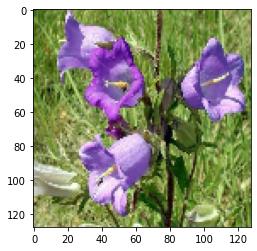

a flat type of purple flower with a yellow and green pistil area <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
5


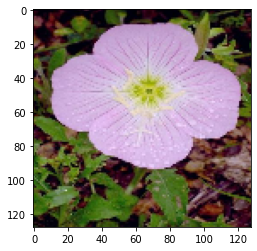

this flower has long stamen surrounded by five wide large purple petals with rounded ruffled edges <PAD> <PAD> <PAD> <PAD> 
1571


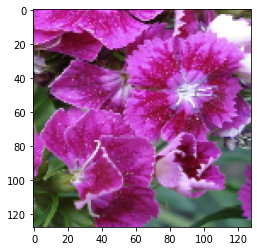

this flower has white petals with pink veins a yellow ovary white pistil and yellow stamen <PAD> <PAD> <PAD> <PAD> 
5676


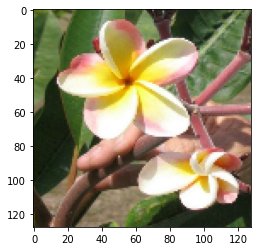

this flower has overlapping pink petals with veins and rounded edges <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
6027


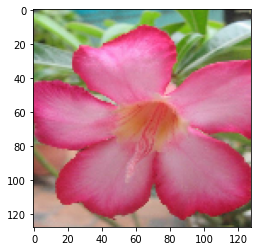

this flower has a large pink petal below three smaller pink and red petals <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
6190


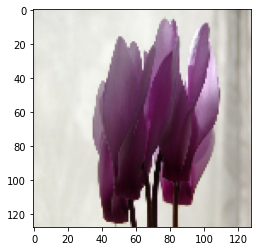

this flower has petals that are white and has yellow and purple lines <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
3162


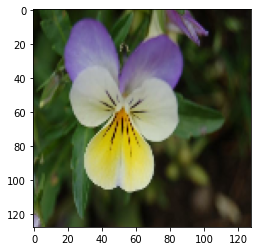

this flower is unique because the petals are big and round that go downward and are purple and white <PAD> 
288


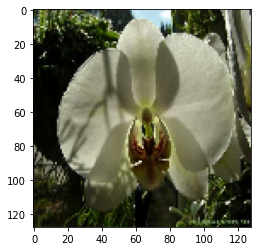

the petals on this flower are white and pink and the pedicel is dark brown <PAD> <PAD> <PAD> <PAD> <PAD> 
3560


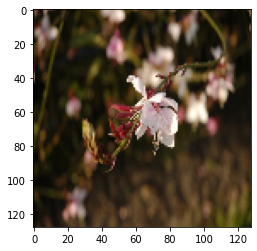

this flower is pink and white in color with multi colored petals <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
4502


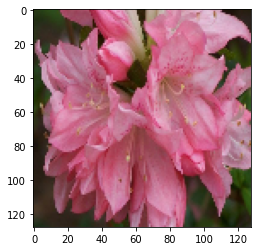

the flower has petals that are purple yellow and brown <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
5101


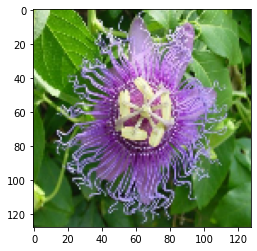

In [51]:
%matplotlib inline
def cosine_similarity(image_features, text_features):
    # Image-text compatibility scores
    image_features = tf.nn.l2_normalize(image_features, axis=1)
    text_features = tf.nn.l2_normalize(text_features, axis=1)
    scores = tf.reduce_sum(image_features * text_features, axis=1)
    return tf.reduce_sum(scores)

for i, (img, caption) in enumerate(dataset):
    hidden = text_encoder.initialize_hidden_state()
    v, _ = text_encoder(caption, hidden)
    cos_sim = 0
    index = -1
    sim_img = None
    for j in range(encoded_img.shape[0]):
        cur_image = tf.expand_dims(encoded_img[j], axis=0)
        cur_v = tf.expand_dims(v[0], axis=0)
        # print(cosine_similarity(cur_image, cur_v))
        if cosine_similarity(cur_image, cur_v) > cos_sim:
            cos_sim = cosine_similarity(cur_image, cur_v)
            index = j
            sim_img = cur_image
    for j in caption[0].numpy():
        print(id2word_dict[str(j.item())], end=' ')
    print('')
    # show image
    print(index)
    plt.imshow(raw_img[index])
    plt.show()
    if i == 10:
        break